In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer

from transformers import pipeline

from scipy import stats

In [2]:
def process_batch(batchn):
    og_scores = list(pd.read_csv(f"../scores/persp_score_original_{batchn}.csv")["score"])
    aave_scores = list(pd.read_csv(f"../scores/persp_score_aave_{batchn}.csv")["score"])
    nigerianD_scores = list(pd.read_csv(f"../scores/persp_score_nigerianD_{batchn}.csv")["score"])
    indianD_scores = list(pd.read_csv(f"../scores/persp_score_indianD_{batchn}.csv")["score"])
    singlish_scores = list(pd.read_csv(f"../scores/persp_score_singlish_{batchn}.csv")["score"])

    og_errors = json.load(open(f"../scores/errors_original_{batchn}.json"))
    aave_errors = json.load(open(f"../scores/errors_aave_{batchn}.json"))
    nigerianD_errors = json.load(open(f"../scores/errors_nigerianD_{batchn}.json"))
    indianD_errors = json.load(open(f"../scores/errors_indianD_{batchn}.json"))
    singlish_errors = json.load(open(f"../scores/errors_singlish_{batchn}.json"))
            
    for idx in og_errors:
        og_scores.insert(idx, 0)    
    for idx in aave_errors:
        aave_scores.insert(idx, 0)
    for idx in nigerianD_errors:
        nigerianD_scores.insert(idx, 0)
    for idx in indianD_errors:
        indianD_scores.insert(idx, 0)
    for idx in singlish_errors:
        singlish_scores.insert(idx, 0)
    
    to_drop = sorted(list(set(og_errors + aave_errors + nigerianD_errors + indianD_errors + singlish_errors)), reverse=True)

    for idx in to_drop:
        del og_scores[idx]
        del aave_scores[idx]
        del nigerianD_scores[idx]
        del indianD_scores[idx]
        del singlish_scores[idx]

    return og_scores, aave_scores, nigerianD_scores, indianD_scores, singlish_scores, to_drop

In [3]:
og1, aave1, nigerianD1, indianD1, singlish1, to_drop1 = process_batch("batch1")
og2, aave2, nigerianD2, indianD2, singlish2, to_drop2 = process_batch("batch2")
og3, aave3, nigerianD3, indianD3, singlish3, to_drop3 = process_batch("batch3")
og4, aave4, nigerianD4, indianD4, singlish4, to_drop4 = process_batch("batch4")

In [4]:
og_scores = og1 + og2 + og3 + og4
aave_scores = aave1 + aave2 + aave3 + aave4
nigerianD_scores = nigerianD1 + nigerianD2 + nigerianD3 + nigerianD4
indianD_scores = indianD1 + indianD2 + indianD3 + indianD4
singlish_scores = singlish1 + singlish2 + singlish3 + singlish4

to_drop2 = [i+5000 for i in to_drop2]
to_drop3 = [i+10000 for i in to_drop3]
to_drop4 = [i+15000 for i in to_drop4]
to_drop = sorted(to_drop1 + to_drop2 + to_drop3 + to_drop4, reverse=True)

# check if all errors are removed
print(len(og_scores), len(aave_scores), len(nigerianD_scores), len(indianD_scores), len(singlish_scores))

20047 20047 20047 20047 20047


In [5]:
print("original found toxic:", len([score for score in og_scores if score > 0.5]))
print("AAVE found toxic:", len([score for score in aave_scores if score > 0.5]))
print("nigerianD found toxic:", len([score for score in nigerianD_scores if score > 0.5]))
print("indianD found toxic:", len([score for score in indianD_scores if score > 0.5]))
print("Singlish found toxic:", len([score for score in singlish_scores if score > 0.5]))

original found toxic: 12089
AAVE found toxic: 11819
nigerianD found toxic: 12057
indianD found toxic: 11684
Singlish found toxic: 12053


## sanity check of PerspectiveAPI's results on the original sentences

In [8]:
# read in the gold label of the original sentences
df = pd.read_json(f"../data/hatexplain_original.json").transpose()

gold_labels = []
for i in range(len(df)):
    annotations = [an["label"] for an in df["annotators"].iloc[i]]

    # if less than two annotators labeled current sentence as normal, consider it toxic
    if annotations.count("normal") < 2:
        gold_labels.append(1)
    else: 
        gold_labels.append(0)
    
# drop error indexes
for idx in to_drop:
    del gold_labels[idx]

# check the distribution of gold labels
print(Counter(gold_labels))

Counter({1: 12276, 0: 7771})


In [9]:
# indexes of instances that are toxic or non-toxic accroding to gold labels
gtox_idx = [i for i in range(len(gold_labels)) if gold_labels[i] == 1]
gntox_idx = [i for i in range(len(gold_labels)) if gold_labels[i] == 0]

# toxic instances that are labeled as toxic by the Perspective
tox_idx_persp = []
for i in range(len(og_scores)):
    if og_scores[i] > 0.5:
        tox_idx_persp.append(i)

print("gold toxic instances:", len(gtox_idx))
print("toxic instances found by Perspective:", len(tox_idx_persp))

gold toxic instances: 12276
toxic instances found by Perspective: 12089


In [10]:
from scipy.stats import chi2_contingency

# since the data are categorical, we choose he Chi-square test
# the null hypothesis is that the two categorical variables are independent

persp_labels_og = [0 if i < 0.5 else 1 for i in og_scores]  # transform the scores to binary labels

# create a contingency table
contingency_table = pd.crosstab(pd.Series(gold_labels, name='gold'), pd.Series(persp_labels_og, name='perspective'))

# perform the Chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")
# p == 0 < 0.05, reject the null hypothesis, the two categorical variables are dependent

Chi-square statistic: 1799.3058060958044
P-value: 0.0


The Chi-square statistic and the p-value are used to determine whether there is a significant association between two categorical variables.

The Chi-square statistic of 1799.3058060958044 is quite large, which indicates a high degree of association between the two variables.

The p-value of 0.0 is less than the typical threshold of 0.05, which means the result is statistically significant. In other words, the probability of observing a Chi-square statistic as extreme as 1799.3058060958044 (or more extreme) under the null hypothesis (which is that the variables are independent) is virtually zero. Therefore, you would reject the null hypothesis and conclude that there is a significant association between the two variables.

In summary, these results suggest that the two lists you tested are not independent and have a significant association.

## PerspectiveAPI's results are fairly similar to the gold labels, based on 0.5 transformation threshold

## Question 1: toxicity score cap on gold toxic posts

Given: toxicity scores by PerspectiveAPI on original sentences and parallel dialect sentences

Question: Is it the case that already toxic posts are less likely to get more toxic, because there is a cap there,

but the gold non-toxic posts are more likely getting more toxic with conversion because of the rules and features of non standard English languages.

In [11]:
# given gold toxic labels, check how Perspective API scores the sentences
gtox_og_scores = []
gtox_aave_scores = []
gtox_nigeriand_scores = []
gtox_indiand_scores = []
gtox_singlish_scores = []

# given gold non-toxic labels, check how Perspective API scores the sentences
gntox_og_scores = []
gntox_aave_scores = []
gntox_nigeriand_scores = []
gntox_indiand_scores = []
gntox_singlish_scores = []

for i in range(len(gold_labels)):
    if gold_labels[i] == 1:
        gtox_og_scores.append(og_scores[i])
        gtox_aave_scores.append(aave_scores[i])
        gtox_nigeriand_scores.append(nigerianD_scores[i])
        gtox_indiand_scores.append(indianD_scores[i])
        gtox_singlish_scores.append(singlish_scores[i])
    else:
        gntox_og_scores.append(og_scores[i])
        gntox_aave_scores.append(aave_scores[i])
        gntox_nigeriand_scores.append(nigerianD_scores[i])
        gntox_indiand_scores.append(indianD_scores[i])
        gntox_singlish_scores.append(singlish_scores[i])

In [12]:
# use t-test to see if the difference between original and aave toxicity scores is significant
print(stats.ttest_ind(gntox_og_scores, gntox_aave_scores))
print(stats.ttest_ind(gtox_og_scores, gtox_aave_scores))

TtestResult(statistic=1.2293165191870719, pvalue=0.21897176892405176, df=15540.0)
TtestResult(statistic=4.451091281968788, pvalue=8.581099899221033e-06, df=24550.0)


In [13]:
print(len(gtox_og_scores))
print(len(gtox_aave_scores))

tox_inc = [(a, b) for a, b in zip(gtox_og_scores, gtox_aave_scores) if a < b]
tox_dec = [(a, b) for a, b in zip(gtox_og_scores, gtox_aave_scores) if a > b]

print(len(tox_inc))
# 3418/12276: given gold toxic, way less than a half of aave sentences suffer from toxicity increase comprered to the original 
# print(len(tox_dec))

12276
12276
3418


In [14]:
print(len(gntox_og_scores))
print(len(gntox_aave_scores))

tox_inc = [(a, b) for a, b in zip(gntox_og_scores, gntox_aave_scores) if a < b]
tox_dec = [(a, b) for a, b in zip(gntox_og_scores, gntox_aave_scores) if a > b]

print(len(tox_inc))
# 3142/7771: given gold non-toxic instances, about a half of aave sentences suffer from toxicity increase
# print(len(tox_dec))

7771
7771
3142


In [15]:
tox_inc = [(a, b) for a, b in zip(gtox_og_scores, gtox_nigeriand_scores) if a < b]
tox_dec = [(a, b) for a, b in zip(gtox_og_scores, gtox_nigeriand_scores) if a > b]
print(len(gtox_nigeriand_scores), len(tox_inc))
# print(len(tox_dec))

tox_inc = [(a, b) for a, b in zip(gntox_og_scores, gntox_nigeriand_scores) if a < b]
tox_dec = [(a, b) for a, b in zip(gntox_og_scores, gntox_nigeriand_scores) if a > b]
print(len(gntox_nigeriand_scores), len(tox_inc), "\n")
# print(len(tox_dec))

# --------------------
tox_inc = [(a, b) for a, b in zip(gtox_og_scores, gtox_indiand_scores) if a < b]
tox_dec = [(a, b) for a, b in zip(gtox_og_scores, gtox_indiand_scores) if a > b]
print(len(gtox_indiand_scores), len(tox_inc))
# print(len(tox_dec))

tox_inc = [(a, b) for a, b in zip(gntox_og_scores, gntox_indiand_scores) if a < b]
tox_dec = [(a, b) for a, b in zip(gntox_og_scores, gntox_indiand_scores) if a > b]
print(len(gntox_indiand_scores), len(tox_inc), "\n")
# print(len(tox_dec))

# --------------------
tox_inc = [(a, b) for a, b in zip(gtox_og_scores, gtox_singlish_scores) if a < b]
tox_dec = [(a, b) for a, b in zip(gtox_og_scores, gtox_singlish_scores) if a > b]
print(len(gtox_singlish_scores), len(tox_inc))
# print(len(tox_dec))

tox_inc = [(a, b) for a, b in zip(gntox_og_scores, gntox_singlish_scores) if a < b]
tox_dec = [(a, b) for a, b in zip(gntox_og_scores, gntox_singlish_scores) if a > b]
print(len(gntox_singlish_scores), len(tox_inc))
# print(len(tox_dec))

12276 4591
7771 3507 

12276 3348
7771 3136 

12276 5311
7771 4131


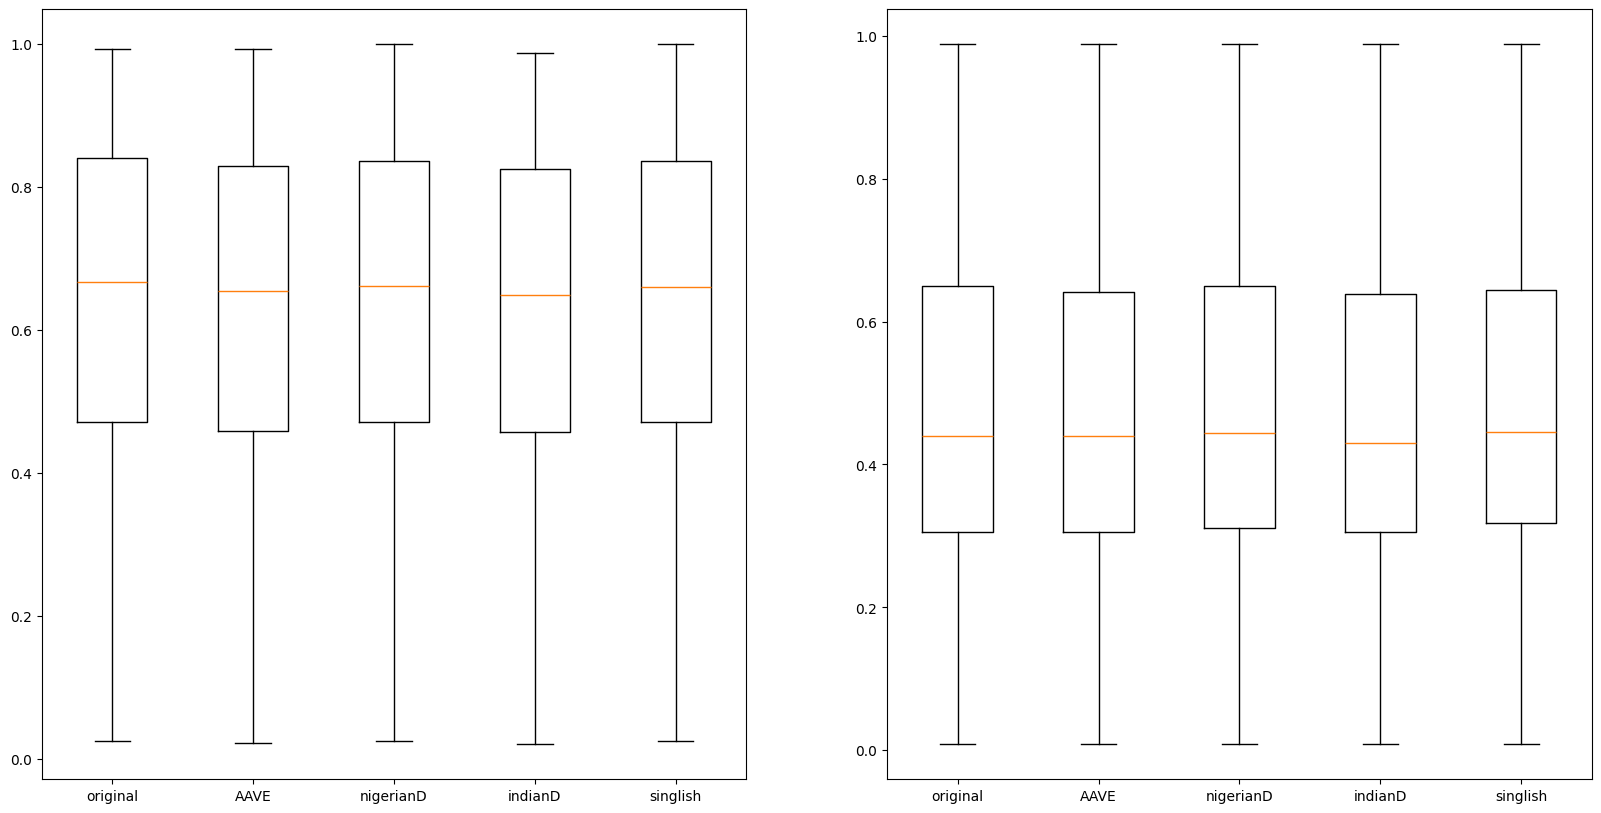

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.boxplot([gtox_og_scores, gtox_aave_scores, gtox_nigeriand_scores, gtox_indiand_scores, gtox_singlish_scores], labels=["original", "AAVE", "nigerianD", "indianD", "singlish"]);

plt.subplot(1, 2, 2)
plt.boxplot([gntox_og_scores, gntox_aave_scores, gntox_nigeriand_scores, gntox_indiand_scores, gntox_singlish_scores], labels=["original", "AAVE", "nigerianD", "indianD", "singlish"]);
# left: only instances are gold toxic, how does Perspective API score all dialects
# right: only instances are gold non-toxic, how does Perspective API score all dialects

In [15]:
# use t-test to see if the difference between original and other dialects' toxicity scores is significant
print("nigerianD vs. original")
print(stats.ttest_ind(gntox_og_scores, gntox_nigeriand_scores))
print(stats.ttest_ind(gtox_og_scores, gtox_nigeriand_scores))

print("indianD vs. original")
print(stats.ttest_ind(gntox_og_scores, gntox_indiand_scores))
print(stats.ttest_ind(gtox_og_scores, gtox_indiand_scores))

print("singlish vs. original")
print(stats.ttest_ind(gntox_og_scores, gntox_singlish_scores))
print(stats.ttest_ind(gtox_og_scores, gtox_singlish_scores))

nigerianD vs. original
TtestResult(statistic=-0.5626171763315466, pvalue=0.57370370921843, df=15540.0)
TtestResult(statistic=1.0364324972518117, pvalue=0.30001062443340987, df=24550.0)
indianD vs. original
TtestResult(statistic=1.9780951684354016, pvalue=0.04793560573179975, df=15540.0)
TtestResult(statistic=5.800984464095573, pvalue=6.673580158935097e-09, df=24550.0)
singlish vs. original
TtestResult(statistic=-0.9770230930233429, pvalue=0.3285729286675051, df=15540.0)
TtestResult(statistic=1.5981327078064393, pvalue=0.11002631524502754, df=24550.0)


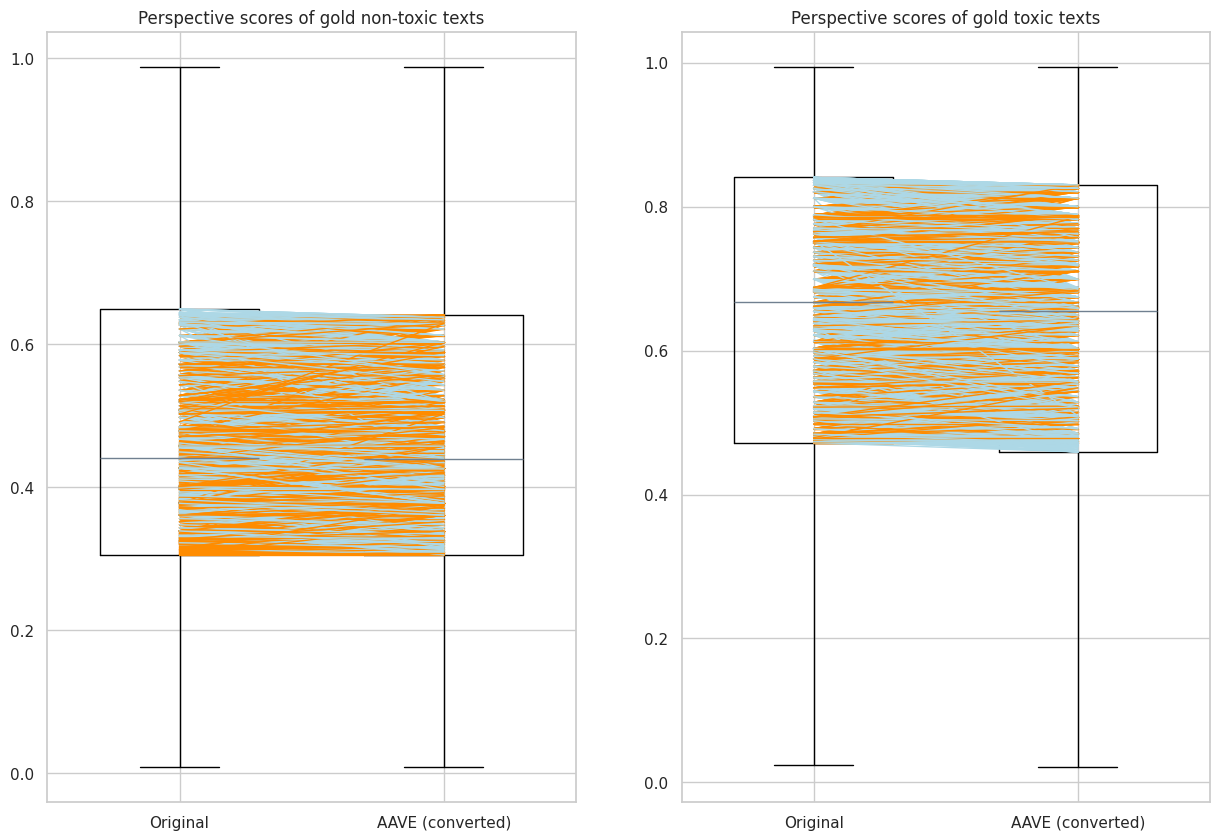

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure and two subplots with a larger height
fig, ax = plt.subplots(ncols=2, figsize=(15, 10))  # Adjust the first value to increase the width

# Calculate quartiles for each set of scores
q1_gntox_og, q3_gntox_og = np.percentile(gntox_og_scores, [25, 75])
q1_gntox_aave, q3_gntox_aave = np.percentile(gntox_aave_scores, [25, 75])
q1_gtox_og, q3_gtox_og = np.percentile(gtox_og_scores, [25, 75])
q1_gtox_aave, q3_gtox_aave = np.percentile(gtox_aave_scores, [25, 75])

# Create boxplots and lines for model 1 and model 2
ax[0].boxplot([gntox_og_scores, gntox_aave_scores], positions=[1, 2], widths=0.6, medianprops={'color':'slategrey'})
for i in range(len(gntox_og_scores)):
    if q1_gntox_og <= gntox_og_scores[i] <= q3_gntox_og and q1_gntox_aave <= gntox_aave_scores[i] <= q3_gntox_aave:
        if gntox_og_scores[i] > gntox_aave_scores[i]:
            color = 'lightblue'
        else:
            color = 'darkorange'
        ax[0].plot([1, 2], [gntox_og_scores[i], gntox_aave_scores[i]], color=color, linestyle='-', linewidth=1)
ax[0].set_xticks([1, 2])
ax[0].set_xticklabels(['Original', 'AAVE (converted)'])
ax[0].set_title('Perspective scores of gold non-toxic texts')  # Add caption to the left plot

# Create boxplots and lines for model 3 and model 4
ax[1].boxplot([gtox_og_scores, gtox_aave_scores], positions=[1, 2], widths=0.6, medianprops={'color':'slategrey'})
for i in range(len(gtox_og_scores)):
    if q1_gtox_og <= gtox_og_scores[i] <= q3_gtox_og and q1_gtox_aave <= gtox_aave_scores[i] <= q3_gtox_aave:
        if gtox_og_scores[i] > gtox_aave_scores[i]:
            color = 'lightblue'
        else:
            color = 'darkorange'
        ax[1].plot([1, 2], [gtox_og_scores[i], gtox_aave_scores[i]], color=color, linestyle='-', linewidth=1)
ax[1].set_xticks([1, 2])
ax[1].set_xticklabels(['Original', 'AAVE (converted)'])
ax[1].set_title('Perspective scores of gold toxic texts')  # Add caption to the right plot

plt.show()

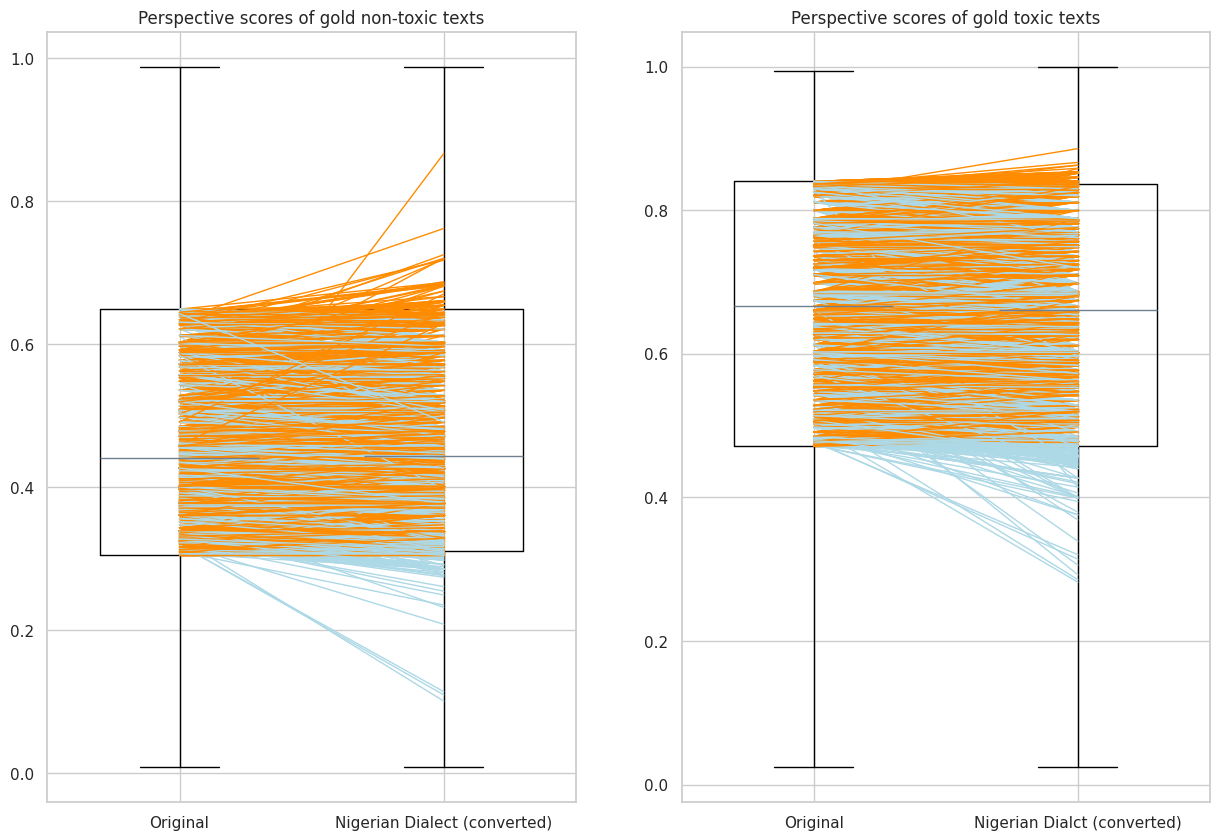

In [41]:
# Create a figure and two subplots with a larger height
fig, ax = plt.subplots(ncols=2, figsize=(15, 10))  # Adjust the first value to increase the width

# Calculate quartiles for each set of scores
q1_gntox_og, q3_gntox_og = np.percentile(gntox_og_scores, [25, 75])
q1_gntox_nigeriand, q3_gntox_aave = np.percentile(gntox_aave_scores, [25, 75])
q1_gtox_og, q3_gtox_og = np.percentile(gtox_og_scores, [25, 75])
q1_gtox_nigeriand, q3_gtox_aave = np.percentile(gtox_aave_scores, [25, 75])

# Create boxplots and lines for model 1 and model 2
ax[0].boxplot([gntox_og_scores, gntox_nigeriand_scores], positions=[1, 2], widths=0.6, medianprops={'color':'slategrey'})
for i in range(len(gntox_og_scores)):
    if q1_gntox_og <= gntox_og_scores[i] <= q3_gntox_og and q1_gntox_nigeriand <= gntox_aave_scores[i] <= q3_gntox_aave:
        if gntox_og_scores[i] > gntox_nigeriand_scores[i]:
            color = 'lightblue'
        else:
            color = 'darkorange'
        ax[0].plot([1, 2], [gntox_og_scores[i], gntox_nigeriand_scores[i]], color=color, linestyle='-', linewidth=1)
ax[0].set_xticks([1, 2])
ax[0].set_xticklabels(['Original', 'Nigerian Dialect (converted)'])
ax[0].set_title('Perspective scores of gold non-toxic texts')  # Add caption to the left plot

# Create boxplots and lines for model 3 and model 4
ax[1].boxplot([gtox_og_scores, gtox_nigeriand_scores], positions=[1, 2], widths=0.6, medianprops={'color':'slategrey'})
for i in range(len(gtox_og_scores)):
    if q1_gtox_og <= gtox_og_scores[i] <= q3_gtox_og and q1_gtox_nigeriand <= gtox_aave_scores[i] <= q3_gtox_aave:
        if gtox_og_scores[i] > gtox_nigeriand_scores[i]:
            color = 'lightblue'
        else:
            color = 'darkorange'
        ax[1].plot([1, 2], [gtox_og_scores[i], gtox_nigeriand_scores[i]], color=color, linestyle='-', linewidth=1)
ax[1].set_xticks([1, 2])
ax[1].set_xticklabels(['Original', 'Nigerian Dialct (converted)'])
ax[1].set_title('Perspective scores of gold toxic texts')  # Add caption to the right plot

plt.show()

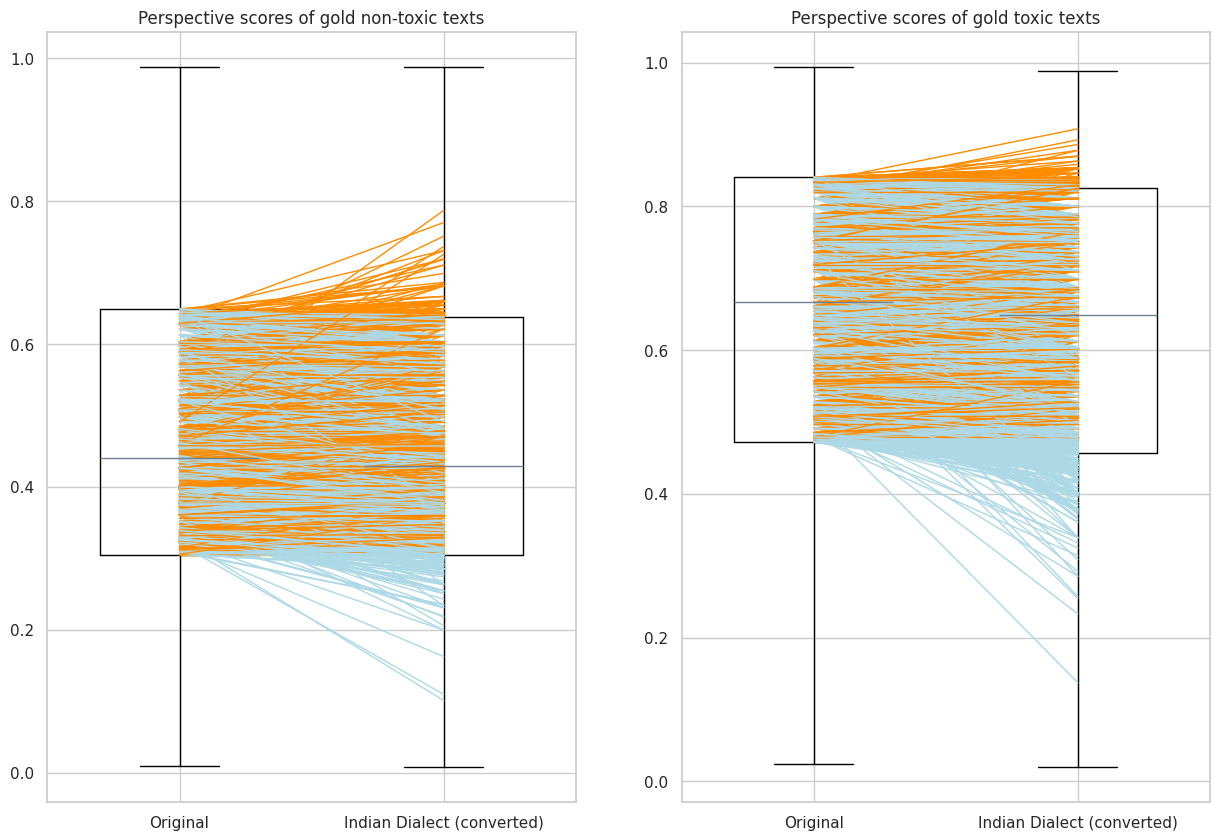

In [42]:
# Create a figure and two subplots with a larger height
fig, ax = plt.subplots(ncols=2, figsize=(15, 10))  # Adjust the first value to increase the width

# Calculate quartiles for each set of scores
q1_gntox_og, q3_gntox_og = np.percentile(gntox_og_scores, [25, 75])
q1_gntox_indiand, q3_gntox_aave = np.percentile(gntox_aave_scores, [25, 75])
q1_gtox_og, q3_gtox_og = np.percentile(gtox_og_scores, [25, 75])
q1_gtox_indiand, q3_gtox_aave = np.percentile(gtox_aave_scores, [25, 75])

# Create boxplots and lines for model 1 and model 2
ax[0].boxplot([gntox_og_scores, gntox_indiand_scores], positions=[1, 2], widths=0.6, medianprops={'color':'slategrey'})
for i in range(len(gntox_og_scores)):
    if q1_gntox_og <= gntox_og_scores[i] <= q3_gntox_og and q1_gntox_indiand <= gntox_aave_scores[i] <= q3_gntox_aave:
        if gntox_og_scores[i] > gntox_indiand_scores[i]:
            color = 'lightblue'
        else:
            color = 'darkorange'
        ax[0].plot([1, 2], [gntox_og_scores[i], gntox_indiand_scores[i]], color=color, linestyle='-', linewidth=1)
ax[0].set_xticks([1, 2])
ax[0].set_xticklabels(['Original', 'Indian Dialect (converted)'])
ax[0].set_title('Perspective scores of gold non-toxic texts')  # Add caption to the left plot

# Create boxplots and lines for model 3 and model 4
ax[1].boxplot([gtox_og_scores, gtox_indiand_scores], positions=[1, 2], widths=0.6, medianprops={'color':'slategrey'})
for i in range(len(gtox_og_scores)):
    if q1_gtox_og <= gtox_og_scores[i] <= q3_gtox_og and q1_gtox_indiand <= gtox_aave_scores[i] <= q3_gtox_aave:
        if gtox_og_scores[i] > gtox_indiand_scores[i]:
            color = 'lightblue'
        else:
            color = 'darkorange'
        ax[1].plot([1, 2], [gtox_og_scores[i], gtox_indiand_scores[i]], color=color, linestyle='-', linewidth=1)
ax[1].set_xticks([1, 2])
ax[1].set_xticklabels(['Original', 'Indian Dialect (converted)'])
ax[1].set_title('Perspective scores of gold toxic texts')  # Add caption to the right plot

plt.show()

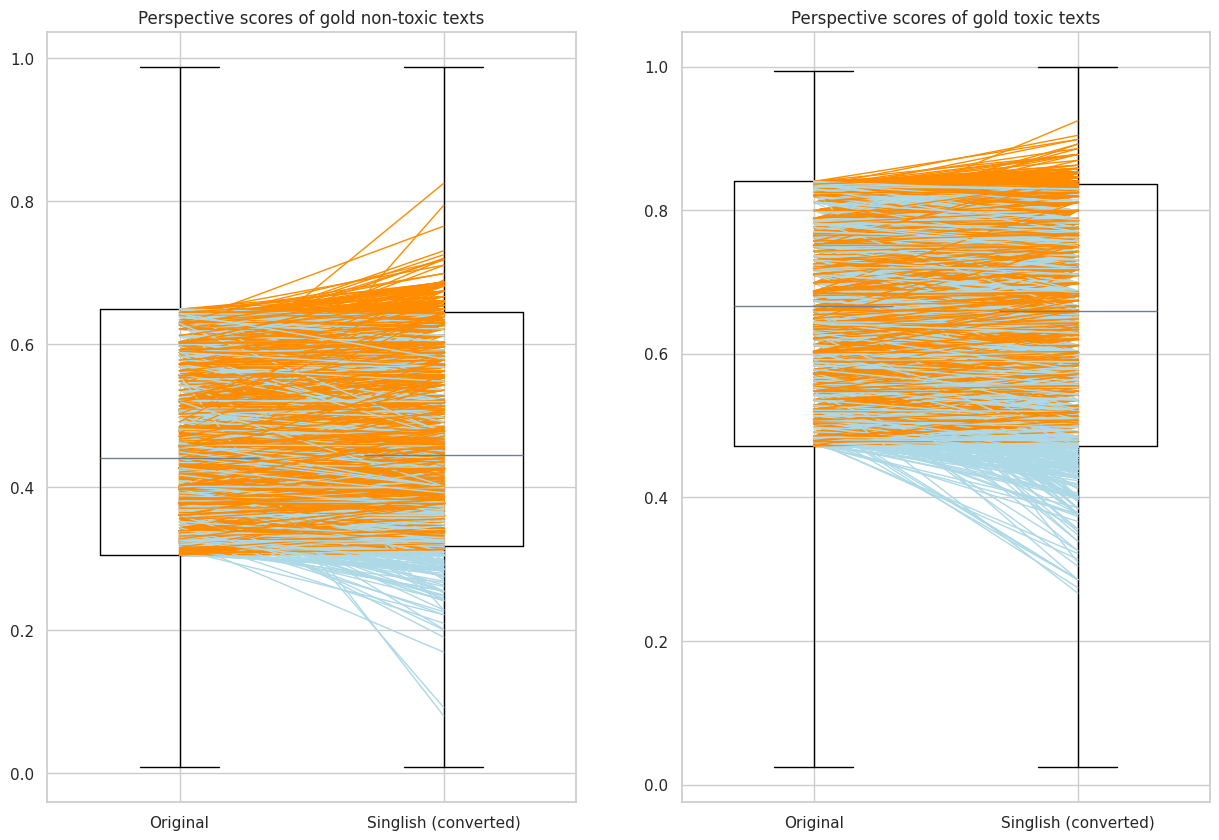

In [43]:
# Create a figure and two subplots with a larger height
fig, ax = plt.subplots(ncols=2, figsize=(15, 10))  # Adjust the first value to increase the width

# Calculate quartiles for each set of scores
q1_gntox_og, q3_gntox_og = np.percentile(gntox_og_scores, [25, 75])
q1_gntox_singlish, q3_gntox_aave = np.percentile(gntox_aave_scores, [25, 75])
q1_gtox_og, q3_gtox_og = np.percentile(gtox_og_scores, [25, 75])
q1_gtox_singlish, q3_gtox_aave = np.percentile(gtox_aave_scores, [25, 75])

# Create boxplots and lines for model 1 and model 2
ax[0].boxplot([gntox_og_scores, gntox_singlish_scores], positions=[1, 2], widths=0.6, medianprops={'color':'slategrey'})
for i in range(len(gntox_og_scores)):
    if q1_gntox_og <= gntox_og_scores[i] <= q3_gntox_og and q1_gntox_singlish <= gntox_aave_scores[i] <= q3_gntox_aave:
        if gntox_og_scores[i] > gntox_singlish_scores[i]:
            color = 'lightblue'
        else:
            color = 'darkorange'
        ax[0].plot([1, 2], [gntox_og_scores[i], gntox_singlish_scores[i]], color=color, linestyle='-', linewidth=1)
ax[0].set_xticks([1, 2])
ax[0].set_xticklabels(['Original', 'Singlish (converted)'])
ax[0].set_title('Perspective scores of gold non-toxic texts')  # Add caption to the left plot

# Create boxplots and lines for model 3 and model 4
ax[1].boxplot([gtox_og_scores, gtox_singlish_scores], positions=[1, 2], widths=0.6, medianprops={'color':'slategrey'})
for i in range(len(gtox_og_scores)):
    if q1_gtox_og <= gtox_og_scores[i] <= q3_gtox_og and q1_gtox_singlish <= gtox_aave_scores[i] <= q3_gtox_aave:
        if gtox_og_scores[i] > gtox_singlish_scores[i]:
            color = 'lightblue'
        else:
            color = 'darkorange'
        ax[1].plot([1, 2], [gtox_og_scores[i], gtox_singlish_scores[i]], color=color, linestyle='-', linewidth=1)
ax[1].set_xticks([1, 2])
ax[1].set_xticklabels(['Original', 'Singlish (converted)'])
ax[1].set_title('Perspective scores of gold toxic texts')  # Add caption to the right plot

plt.show()

## Question 2

In [11]:
import numpy as np
from scipy.stats import ttest_rel

# Paired t-test
# given: only gold non-toxic instances
# test: how the perspective API scores the original sentences and AAVE dialects 
t_statistic, p_value = ttest_rel(gntox_og_scores, gntox_aave_scores)

# Print the results
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

# Interpretation of the result
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis (significant difference between the scores).")
else:
    print("Fail to reject the null hypothesis (no significant difference between the scores).")


T-statistic: 9.585699942889994
P-value: 1.20946528341701e-21
Reject the null hypothesis (significant difference between the scores).


In [12]:
# Paired t-test
# given: only gold toxic instances
# test: how the perspective API scores the original sentences and AAVE dialects 
t_statistic, p_value = ttest_rel(gtox_og_scores, gtox_aave_scores)

# Print the results
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

# Interpretation of the result
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis (significant difference between the scores).")
else:
    print("Fail to reject the null hypothesis (no significant difference between the scores).")

T-statistic: 32.21037159944754
P-value: 1.3663633663741608e-218
Reject the null hypothesis (significant difference between the scores).


In [13]:
# Paired t-test
# given: only gold non-toxic instances
# test: how the perspective API scores the original sentences and nigeriand dialects 
t_statistic, p_value = ttest_rel(gntox_og_scores, gntox_nigeriand_scores)

# Print the results
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

# Interpretation of the result
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis (significant difference between the scores).")
else:
    print("Fail to reject the null hypothesis (no significant difference between the scores).")

print("-" * 50)

# Paired t-test
# given: only gold toxic instances
# test: how the perspective API scores the original sentences and nigeriand dialects 
t_statistic, p_value = ttest_rel(gtox_og_scores, gtox_nigeriand_scores)

# Print the results
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

# Interpretation of the result
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis (significant difference between the scores).")
else:
    print("Fail to reject the null hypothesis (no significant difference between the scores).")

T-statistic: -4.880621216227116
P-value: 1.0785895427150844e-06
Reject the null hypothesis (significant difference between the scores).
--------------------------------------------------
T-statistic: 9.246618103567101
P-value: 2.696504369252737e-20
Reject the null hypothesis (significant difference between the scores).


In [92]:
def check_increase_decrease(og_scores, converted_scores):
    increase = []
    decrease = []

    for i in range(len(og_scores)):
        if converted_scores[i] > og_scores[i]:
            increase.append((i, converted_scores[i] - og_scores[i]))
        elif converted_scores[i] < og_scores[i]:
            decrease.append((i, og_scores[i] - converted_scores[i]))

    return increase, decrease

In [93]:
def get_rule_importance(converted_df, converted_scores, og_scores, to_drop):
    """
    Get the rules that are most likely to cause an increase or decrease in toxicity scores.

    converted_df: data frame containing synthetic sentences and the rules and they were applied on
    converted_scores: toxicity scores by PerspectiveAPI of the synthetic sentences
    og_scores: toxicity scores by PerspectiveAPI of the source sentences, len(og_scores) == len(converted_scores)
    to_drop: indexes of all sentences that were not processed by PerspectiveAPI
    """

    # drop all not processed documents from document list
    for idx in to_drop:
        converted_df.drop(idx, inplace=True)
    converted_df.reset_index(drop=True, inplace=True)

    # get indexes of increased and decreased instances
    converted_mtox, og_mtox = check_increase_decrease(og_scores, converted_scores)

    # seperate rules applied on instances with in-/decreased scores
    rules_increase_tox = []  # [[rule1, rule2, ...], [rule1, rule2, ...], ...]
    rules_decrease_tox = []  # [[rule1, rule2, ...], [rule1, rule2, ...], ...]

    # rules on instances for which toxicity increased
    for idx, score_change in converted_mtox:
        rules_increase_tox.append(converted_df["rules"][idx])
    # rules on instances for which toxicity decreased
    for idx, score_change in og_mtox:
        rules_decrease_tox.append(converted_df["rules"][idx])

    # how much did the scores in-/decreased
    increase_degree = [score_change for (idx, score_change) in converted_mtox]
    decrease_degree = [score_change for (idx, score_change) in og_mtox]

    # create rule_sentence_matrix, in which each row represnets a sentence
    # and each column represents a rule, like a bag of words matrix
    vectorizer = (
        CountVectorizer()
    )  # used for creating the rule_sentence_matrix, like BoW

    # convert rule list of each document to a single string for CountVectorizer()
    rules_increase_tox_as_strings = [" ".join(doc) for doc in rules_increase_tox]
    # learn the "vocabulary" dictionary and return term-document matrix
    X = vectorizer.fit_transform(rules_increase_tox_as_strings)
    rule_sent_matrix_increase = pd.DataFrame(
        X.toarray(), columns=vectorizer.get_feature_names_out()
    )

    # do the same for instances with decreased toxicity scores
    rules_decrease_tox_as_strings = [" ".join(doc) for doc in rules_decrease_tox]
    X = vectorizer.fit_transform(rules_decrease_tox_as_strings)
    rule_sent_matrix_decrease= pd.DataFrame(
        X.toarray(), columns=vectorizer.get_feature_names_out()
    )

    # test each rule vector against in-/decrease degree, see if the relevance is significant
    rules_cause_increase = []  # [{rule1_name, (r, p)}, {rule2_name, (r, p)} ...]

    for i in range(len(rule_sent_matrix_increase.columns)):
        column_name = rule_sent_matrix_increase.columns[i]

        # apply a statistic test
        r, p = stats.pointbiserialr(
            rule_sent_matrix_increase[column_name], increase_degree
        )
        if p < 0.05:
            significant = {column_name: (r, p)}
            rules_cause_increase.append(significant)

    rules_cause_increase = sorted(
        rules_cause_increase, key=lambda x: list(x.values())[0][1]
    )

    # do the same for instances with decreased toxicity scores
    rules_cause_decrease = []

    for i in range(len(rule_sent_matrix_decrease.columns)):
        column_name = rule_sent_matrix_decrease.columns[i]

        # apply a statistic test
        r, p = stats.pointbiserialr(
            rule_sent_matrix_decrease[column_name], decrease_degree
        )
        if p < 0.05:
            significant = {column_name: (r, p)}
            rules_cause_decrease.append(significant)

    rules_cause_decrease = sorted(
        rules_cause_decrease, key=lambda x: list(x.values())[0][1]
    )

    return rule_sent_matrix_increase, rules_cause_increase, rule_sent_matrix_decrease, rules_cause_decrease

In [94]:
aave_tox, og_tox = check_increase_decrease(og_scores, aave_scores)
print("dialect more toxic", len(aave_tox))
print("original more toxic", len(og_tox))

dialect more toxic 6560
original more toxic 11172


In [95]:
increase_rule_all = []
decrease_rule_all = []

In [96]:
def print_relevant_rules(rules_cause_increase, rules_cause_decrease):
    rule_names_in = sorted([list(rule.keys())[0] for rule in rules_cause_increase])
    rule_names_de = sorted([list(rule.keys())[0] for rule in rules_cause_decrease])

    print("rules that cause increase in toxicity")
    print(len(rule_names_in), rule_names_in)
    print("rules that cause decrease in toxicity")
    print(len(rule_names_de), rule_names_de)

    # check how similar is the rule_names_in and rule_names_de
    print("rules found in both increase and decrease in toxicity")
    intersection = sorted(list(set(rule_names_in).intersection(set(rule_names_de))))
    print(len(intersection), intersection)

    return True

In [97]:
aave_full = pd.read_json("../data/hatexplain/aave_full.jsonl", lines=True)
(
    rule_sent_matrix_increase,
    rules_cause_increase,
    rule_sent_matrix_decrease,
    rules_cause_decrease,
) = get_rule_importance(aave_full, aave_scores, og_scores, to_drop)

print_relevant_rules(rules_cause_increase, rules_cause_decrease)

increase_rule_all += rules_cause_increase
decrease_rule_all += rules_cause_decrease

rules that cause increase in toxicity
22 ['acomp_focusing_like', 'aint_be', 'bare_past_tense', 'chaining_main_verbs', 'clefting', 'demonstrative_for_definite_articles', 'do_tense_marker', 'double_modals', 'drop_copula_be_np', 'for_to', 'generalized_third_person_s', 'mass_noun_plurals', 'null_referential_pronouns', 'past_been', 'plural_to_singular_human', 'progressives', 'proximal_distal_demonstratives', 'referential_thing', 'regularized_plurals', 'she_inanimate_objects', 'to_infinitive', 'zero_plural']
rules that cause decrease in toxicity
28 ['aint_before_main', 'bare_past_tense', 'bare_perfect', 'clefting', 'completive_done', 'demonstrative_for_definite_articles', 'double_comparative', 'drop_aux_be_progressive', 'drop_copula_be_np', 'flat_adj_for_adv', 'for_to', 'future_sub_gon', 'generalized_third_person_s', 'mass_noun_plurals', 'null_genitive', 'null_relcl', 'plural_to_singular_human', 'progressives', 'proximal_distal_demonstratives', 'referential_thing', 'regularized_plurals', 're

In [98]:
len(increase_rule_all)

22

In [99]:
nigerianD_full = pd.read_json("../data/hatexplain/nigerianD_full.jsonl", lines=True)
(
    rule_sent_matrix_increase,
    rules_cause_increase,
    rule_sent_matrix_decrease,
    rules_cause_decrease,
) = get_rule_importance(nigerianD_full, nigerianD_scores, og_scores, to_drop)

print_relevant_rules(rules_cause_increase, rules_cause_decrease)

increase_rule_all += rules_cause_increase
decrease_rule_all += rules_cause_decrease

rules that cause increase in toxicity
10 ['demonstrative_no_number', 'drop_aux_be_progressive', 'drop_inf_to', 'null_prepositions', 'progressives', 'regularized_past_tense', 'regularized_plurals', 'remove_det_definite', 'to_infinitive', 'yall']
rules that cause decrease in toxicity
12 ['corr_conjunction_doubling', 'demonstrative_no_number', 'drop_inf_to', 'mass_noun_plurals', 'null_prepositions', 'present_for_exp_perfect', 'progressives', 'regularized_plurals', 'remove_det_definite', 'shadow_pronouns', 'to_infinitive', 'uninflect']
rules found in both increase and decrease in toxicity
7 ['demonstrative_no_number', 'drop_inf_to', 'null_prepositions', 'progressives', 'regularized_plurals', 'remove_det_definite', 'to_infinitive']


In [100]:
indianD_full = pd.read_json("../data/hatexplain/indianD_full.jsonl", lines=True)
(
    rule_sent_matrix_increase,
    rules_cause_increase,
    rule_sent_matrix_decrease,
    rules_cause_decrease,
) = get_rule_importance(indianD_full, indianD_scores, og_scores, to_drop)

print_relevant_rules(rules_cause_increase, rules_cause_decrease)

increase_rule_all += rules_cause_increase
decrease_rule_all += rules_cause_decrease

rules that cause increase in toxicity
19 ['acomp_focusing_like', 'corr_conjunction_doubling', 'demonstrative_no_number', 'double_obj_order', 'fronting_pobj', 'indef_one', 'mass_noun_plurals', 'null_prepositions', 'null_referential_pronouns', 'null_relcl', 'object_pronoun_drop', 'plural_to_singular_human', 'present_perfect_for_past', 'progressives', 'remove_det_definite', 'remove_det_indefinite', 'shadow_pronouns', 'will_would', 'zero_plural']
rules that cause decrease in toxicity
30 ['acomp_focusing_like', 'definite_abstract', 'definite_for_indefinite_articles', 'demonstrative_for_definite_articles', 'double_comparative', 'drop_aux_be_progressive', 'drop_aux_have', 'existential_there', 'indef_one', 'indefinite_for_definite_articles', 'inverted_indirect_question', 'it_dobj', 'mass_noun_plurals', 'more_much', 'null_genitive', 'null_referential_pronouns', 'null_relcl', 'object_pronoun_drop', 'plural_to_singular_human', 'present_for_exp_perfect', 'present_modals', 'present_perfect_for_past

In [101]:
singlish_full = pd.read_json("../data/hatexplain/singlish_full.jsonl", lines=True)
(
    rule_sent_matrix_increase,
    rules_cause_increase,
    rule_sent_matrix_decrease,
    rules_cause_decrease,
) = get_rule_importance(singlish_full, singlish_scores, og_scores, to_drop)

print_relevant_rules(rules_cause_increase, rules_cause_decrease)

increase_rule_all += rules_cause_increase
decrease_rule_all += rules_cause_decrease

rules that cause increase in toxicity
16 ['acomp_focusing_like', 'bare_past_tense', 'chaining_main_verbs', 'completive_finish', 'drop_aux_yn', 'drop_copula_be_ap', 'existential_got', 'give_passive', 'linking_relcl', 'mass_noun_plurals', 'null_prepositions', 'plural_to_singular_human', 'present_perfect_for_past', 'referential_thing', 'regularized_past_tense', 'remove_det_definite']
rules that cause decrease in toxicity
28 ['acomp_focusing_like', 'bare_past_tense', 'completive_finish', 'demonstrative_for_definite_articles', 'double_comparative', 'drop_aux_be_progressive', 'drop_aux_have', 'drop_aux_yn', 'drop_inf_to', 'existential_it', 'give_passive', 'indef_one', 'inverted_indirect_question', 'it_dobj', 'mass_noun_plurals', 'null_prepositions', 'null_referential_pronouns', 'object_pronoun_drop', 'plural_to_singular_human', 'present_for_exp_perfect', 'present_modals', 'present_perfect_for_past', 'progressives', 'referential_thing', 'regularized_past_tense', 'remove_det_definite', 'uninfl

In [102]:
Counter([list(rule.keys())[0] for rule in increase_rule_all]).most_common(10)

[('progressives', 3),
 ('mass_noun_plurals', 3),
 ('acomp_focusing_like', 3),
 ('plural_to_singular_human', 3),
 ('null_prepositions', 3),
 ('remove_det_definite', 3),
 ('chaining_main_verbs', 2),
 ('bare_past_tense', 2),
 ('null_referential_pronouns', 2),
 ('regularized_plurals', 2)]

In [103]:
Counter([list(rule.keys())[0] for rule in decrease_rule_all]).most_common(10)

[('progressives', 4),
 ('uninflect', 4),
 ('mass_noun_plurals', 4),
 ('demonstrative_for_definite_articles', 3),
 ('drop_aux_be_progressive', 3),
 ('plural_to_singular_human', 3),
 ('double_comparative', 3),
 ('remove_det_definite', 3),
 ('present_for_exp_perfect', 3),
 ('null_relcl', 2)]

In [128]:
[rule for rule in increase_rule_all if list(rule.keys())[0] == "progressives"]

[{'progressives': (0.04394419758375491, 0.0003705015354869477)},
 {'progressives': (0.05465935778605874, 8.58154762127366e-07)},
 {'progressives': (0.02872463159959732, 0.020720819450148923)}]

In [129]:
[rule for rule in decrease_rule_all if list(rule.keys())[0] == "progressives"]

[{'progressives': (0.08919223830845732, 3.547715495689921e-21)},
 {'progressives': (0.10274318774302983, 6.399067836540018e-21)},
 {'progressives': (0.06901424136753077, 4.457756938822442e-14)},
 {'progressives': (0.0716777317106499, 9.306937509222099e-12)}]

In [114]:
increase_rule_all[0].keys()

dict_keys(['clefting'])

In [62]:
aave_full = pd.read_json("../data/hatexplain/aave_full.jsonl", lines=True)
for idx in to_drop:
    aave_full.drop(idx, inplace=True)
    aave_full.reset_index(drop=True, inplace=True)

In [63]:
rules_increased_tox = []
rules_decreased_tox = []

for (idx, score_change) in aave_tox:
    rules_increased_tox.append(aave_full["rules"][idx])
for (idx, score_change) in og_tox:
    rules_decreased_tox.append(aave_full["rules"][idx])

print(len(rules_increased_tox))
print(len(rules_decreased_tox))

6560
11172


In [64]:
increase_degree = [score_change for (idx, score_change) in aave_tox]
decrease_degree = [score_change for (idx, score_change) in og_tox]

In [65]:
# flat rules_incresed_tox
rules_increased_tox_flat = [item for sublist in rules_increased_tox for item in sublist]
rules_decreased_tox_flat = [item for sublist in rules_decreased_tox for item in sublist]
# count rules_increased_tox
rules_increased_tox_count = Counter(rules_increased_tox_flat)
rules_decreased_tox_count = Counter(rules_decreased_tox_flat)
print(rules_increased_tox_count)
print(rules_decreased_tox_count)

Counter({'demonstrative_for_definite_articles': 1703, 'yall': 1460, 'regularized_plurals': 1435, 'uninflect': 1380, 'mass_noun_plurals': 1312, 'zero_plural': 948, 'null_relcl': 852, 'bare_past_tense': 819, 'drop_copula_be_NP': 789, 'indef_one': 661, 'progressives': 661, 'plural_to_singular_human': 660, 'generalized_third_person_s': 650, 'aint_before_main': 607, 'drop_aux_be_progressive': 561, 'negative_concord': 554, 'referential_thing': 539, 'double_modals': 520, 'proximal_distal_demonstratives': 507, 'for_to': 497, 'do_tense_marker': 457, 'past_for_past_participle': 413, 'drop_copula_be_AP': 408, 'bare_perfect': 406, 'acomp_focusing_like': 403, 'clefting': 371, 'aint_be': 340, 'possessives_for_pre': 325, 'regularized_past_tense': 324, 'linking_relcl': 320, 'shadow_pronouns': 316, 'null_referential_pronouns': 316, 'double_comparative': 258, 'no_gender_distinction': 257, 'em_subj_pronoun': 237, 'past_been': 214, 'drop_aux_yn': 206, 'participle_past_tense': 200, 'plural_interrogative': 

In [66]:
# extract increase degree of the first ten documents
increase_degree = increase_degree

# extract rules applied on the first ten documents 
documents = rules_increased_tox

# Join the tokens into a single string for each document
documents = [' '.join(doc) for doc in documents]

# Create an instance of CountVectorizer
vectorizer = CountVectorizer()

# Learn the vocabulary dictionary and return term-document matrix
X = vectorizer.fit_transform(documents)

# Convert the matrix to a DataFrame
df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())


In [67]:
print(increase_degree)
print(df.shape)

# print column names of df
print(len(df.columns))

[0.009089769999999997, 0.03801739999999998, 0.00883510999999998, 0.014341570000000026, 0.04134330000000003, 0.04895963999999997, 0.002359570000000033, 0.01148884, 0.01001668, 0.035991159999999967, 0.016348769999999957, 0.0037847400000000087, 0.004738200000000026, 0.011696490000000004, 0.0019580099999999545, 0.0017992600000000247, 0.004525940000000062, 0.0010606279999999975, 0.02809222, 0.03726505999999996, 0.010727270000000066, 0.017664999999999986, 0.006862099999999982, 0.012755699999999981, 0.021856190000000053, 0.023967599999999978, 0.019393839999999996, 0.011336669999999993, 0.06810551999999992, 0.03530679999999997, 0.05605959999999999, 0.03359924999999997, 0.018657900000000005, 0.009476350000000022, 0.014845500000000067, 0.024875480000000005, 0.017735129999999988, 0.01400828000000004, 0.01571559999999994, 0.06324106000000007, 0.0007421719999999993, 0.037605, 0.07237009999999999, 0.00844986999999997, 0.022033359999999946, 0.010848329999999962, 0.02090852999999998, 0.027689189999999

In [85]:
results = []

for i in range(len(df.columns) - 1):
    column_name = df.columns[i]

    r, p = stats.pointbiserialr(df[column_name], df["increase_degree"])
    if p < 0.05:
        significant = {column_name: (r, p)}
        results.append(significant)

results = sorted(results, key=lambda x: list(x.values())[0][1])

KeyError: 'increase_degree'

## examine TwitterAAE results

### original WH vs. WH -> AAVE

In [ ]:
wh_scores = list(pd.read_csv("../data/twitter_aae/persp_score_wh250.csv")["score"])
aave_scores = list(pd.read_csv("../data/twitter_aae/persp_score_aave250_synth.csv")["score"])

wh_errors = json.load(open(f"../data/twitter_aae/errors_wh250.json"))
aave_errors = json.load(open(f"../data/twitter_aae/errors_aave250_synth.json"))

to_drop = sorted(list(set(wh_errors + aave_errors)), reverse=True)

In [ ]:
aave250_synth = pd.read_json("../data/twitter_aae/aave250_synth.jsonl", lines=True)

(
    rule_sent_matrix_increase,
    rules_cause_increase,
    rule_sent_matrix_decrease,
    rules_cause_decrease,
) = get_rule_importance(aave250_synth, aave_scores, wh_scores, to_drop)

print_relevant_rules(rules_cause_increase, rules_cause_decrease)

2 ['aint_before_main', 'comparative_than']
3 ['aint_before_main', 'clefting', 'irrealis_be_done']
1 ['aint_before_main']


True

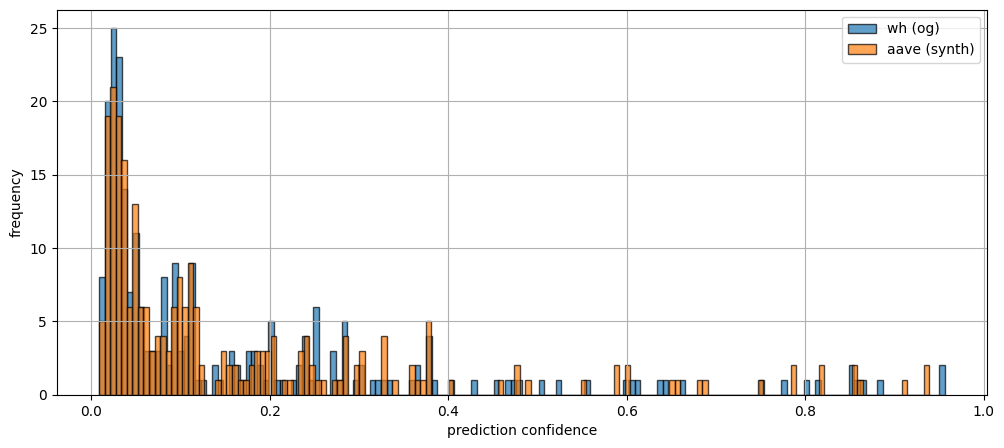

In [ ]:
# plot prediction confidence of different dialects
plt.figure(figsize=(12, 5))

plt.hist(wh_scores, bins=150, edgecolor='black', alpha=0.7, label="wh (og)")
plt.hist(aave_scores, bins=150, edgecolor='black', alpha=0.7, label="aave (synth)")

plt.xlabel('prediction confidence')
plt.ylabel('frequency')
plt.legend()
plt.grid(True)
plt.show()

### original AA vs. AA -> CAD

In [ ]:
aa_scores = list(pd.read_csv("../data/twitter_aae/persp_score_aa250.csv")["score"])
cad_scores = list(pd.read_csv("../data/twitter_aae/persp_score_cad250_synth.csv")["score"])

aa_errors = json.load(open(f"../data/twitter_aae/errors_aa250.json"))
cad_errors = json.load(open(f"../data/twitter_aae/errors_cad250_synth.json"))

to_drop = sorted(list(set(aa_errors + cad_errors)), reverse=True)

In [ ]:
cad250_synth = pd.read_json("../data/twitter_aae/cad250_synth.jsonl", lines=True)

(
    rule_sent_matrix_increase,
    rules_cause_increase,
    rule_sent_matrix_decrease,
    rules_cause_decrease,
) = get_rule_importance(cad250_synth, cad_scores, aa_scores, to_drop)

# decrease in toxicity: rules that de-toxified original AA250 texts
print_relevant_rules(rules_cause_increase, rules_cause_decrease)

2 ['em_subj_pronoun', 'proximal_distal_demonstratives']
1 ['zero_plural']
0 []


True

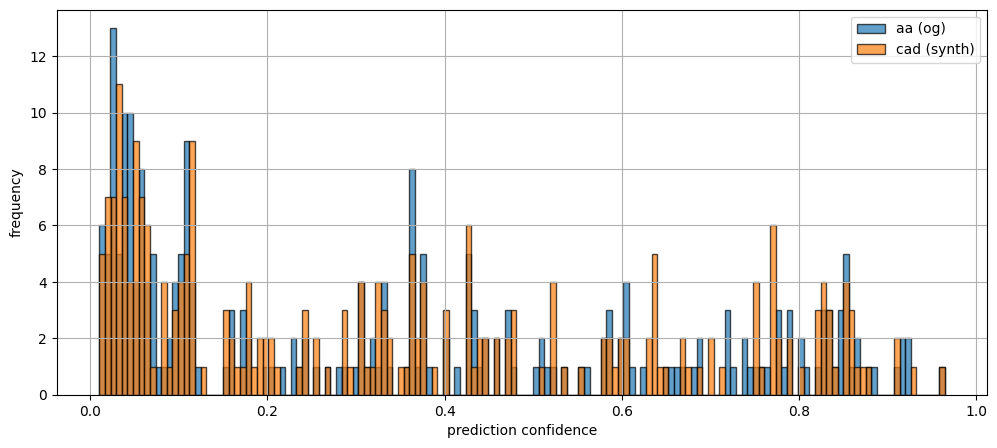

In [ ]:
# plot prediction confidence of different dialects
plt.figure(figsize=(12, 5))

plt.hist(aa_scores, bins=150, edgecolor='black', alpha=0.7, label="aa (og)")
plt.hist(cad_scores, bins=150, edgecolor='black', alpha=0.7, label="cad (synth)")

plt.xlabel('prediction confidence')
plt.ylabel('frequency')
plt.legend()
plt.grid(True)
plt.show()